In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from scipy.io import readsav
from matplotlib import cm
import cartopy.crs as ccrs
from scipy.ndimage import gaussian_filter
import pickle
import glob

homedir = os.path.expanduser("~")
datadir = f"{homedir}/uoedrive/data/gcm_hires/w1049b-sept2025"

In [4]:
# read high-res gcm data
spectrum = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_broaden_time1.txt")
spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time1.txt")
wl = np.loadtxt(f"{datadir}/high-resolution/wavelength_micron.txt")

In [5]:
wl.shape

(460654,)

In [6]:
m_orders = [
    [4.41, 4.47],
    [4.47, 4.54],
    [4.56, 4.63],
    [4.68, 4.75],
    [4.77, 4.84],
    [4.86, 4.93],
]

(27866,)

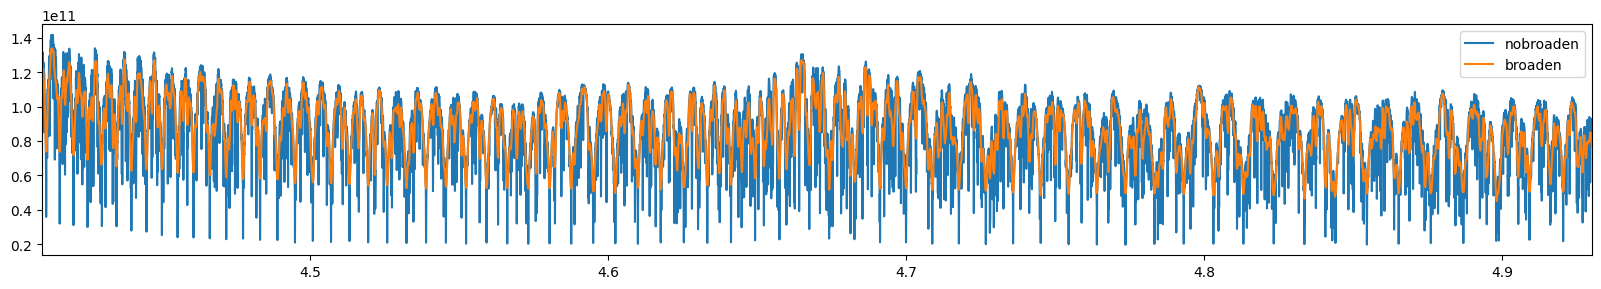

In [7]:
wlind = np.where((wl>np.min(m_orders)) & (wl<np.max(m_orders)))[0]
plt.figure(figsize=(20,3))
plt.plot(wl[wlind], spec_nobroad[wlind], label='nobroaden')
plt.plot(wl[wlind], spectrum[wlind], label='broaden')
plt.xlim(np.min(m_orders), np.max(m_orders))
plt.legend()
wlind.shape

In [8]:
for i in range(len(m_orders)):
    print(np.where((wl>m_orders[i][0]) & (wl<m_orders[i][1]))[0].shape)

(3378,)
(3885,)
(3809,)
(3711,)
(3642,)
(3575,)


In [9]:
# make data pickles
# wav is [nchip, npix]
# obs is [nt, nchip, npix]

npix = 2000
nchip = len(m_orders)
wav = np.empty((nchip, npix))
observed = np.empty((20, nchip, npix))
error = np.empty((20, nchip, npix))
template = np.empty((20, nchip, npix))

for t in range(20):
    spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time{t+1}.txt")
    spectrum = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_broaden_time{t+1}.txt")
    for c in range(nchip):
        wlmin, wlmax = m_orders[c]
        wlind = np.where((wl>wlmin) & (wl<wlmax))[0]
        if len(wlind) != npix:
            x_old = np.linspace(0, 1, len(wlind))
            x_new = np.linspace(0, 1, npix)
            wav[c] = np.interp(x_new, x_old, wl[wlind])
            data = np.interp(x_new, x_old, spectrum[wlind])
            model = np.interp(x_new, x_old, spec_nobroad[wlind])
        else:
            wav[c] = wl[wlind]
            data = spectrum[wlind][:npix]
            model = spec_nobroad[wlind][:npix]
        observed[t,c] = data/np.nanmedian(data)
        template[t,c] = model/np.nanmedian(model)
        size = 5
        sigma = np.array([np.std(observed[t,c][max(0,i-size):min(len(data),i+size+1)]) for i in range(len(data))]) # local running std as error
        error[t,c] = sigma

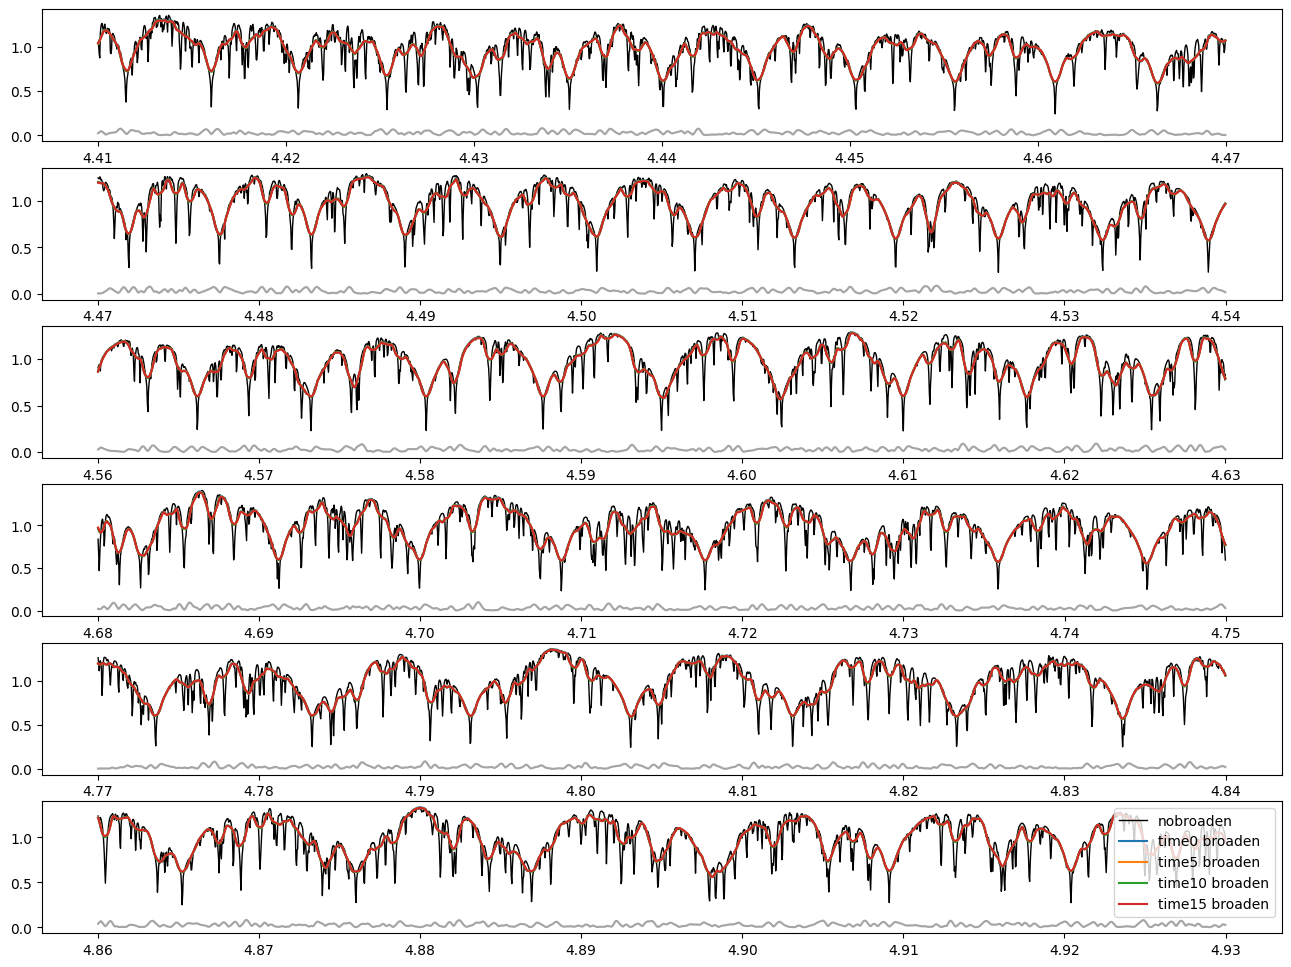

In [12]:
plt.figure(figsize=(16,12))
for c in range(nchip):
    wlmin, wlmax = m_orders[c]
    plt.subplot(nchip,1,c+1)
    plt.plot(wav[c], np.nanmedian(template[:,c,:],axis=0), color='k', linewidth=1, label=f'nobroaden')
    for t in [0,5,10,15]:
        plt.plot(wav[c], observed[t,c], label=f'time{t} broaden')
        plt.plot(wav[c], error[t,c], color='k', alpha=0.1)

plt.legend()

In [13]:
# prepare pickle file
saveout = dict(
    chiplams=np.tile(wav, (20, 1, 1)), 
    chipmodnobroad=template, 
    observed=observed, 
    error=error)
with open(f'../data/fitted/METIS_W1049B_M_gcm.pickle', 'wb') as f:
    pickle.dump(saveout, f)

In [14]:
with open('../data/fitted/METIS_W1049B_M_gcm.pickle', 'rb') as f:
    data = pickle.load(f)
    print(data['chiplams'].shape)

(20, 6, 2000)


In [20]:
# read diamondback model
fname = f"{homedir}/uoedrive/data/diamondback/spectra/t1400g1000f8_m0.0_co1.0.spec"
model = np.loadtxt(fname, skiprows=4)
modwl = model[:,0]
modflux = model[:,1]

(27866,)

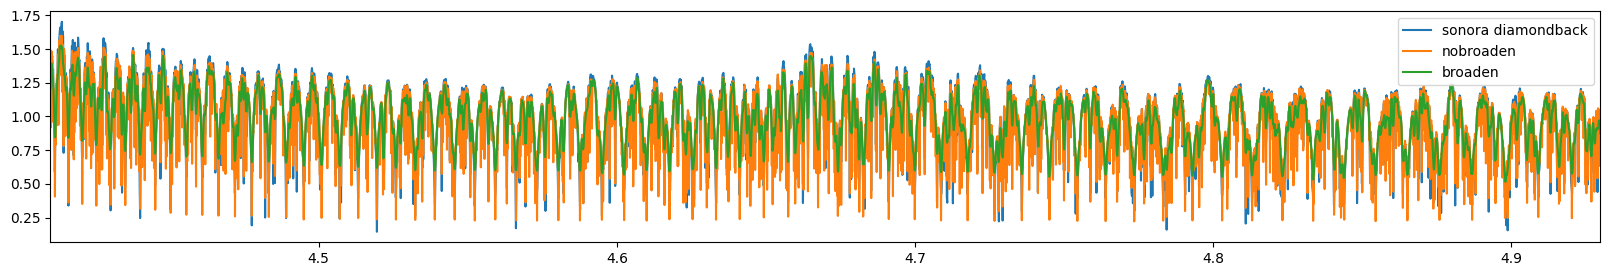

In [21]:
wlind = np.where((modwl>np.min(m_orders)) & (modwl<np.max(m_orders)))[0]
plt.figure(figsize=(20,3))
plt.plot(modwl[wlind], modflux[wlind]/np.nanmedian(modflux[wlind]), label='sonora diamondback')
wlind = np.where((wl>np.min(m_orders)) & (wl<np.max(m_orders)))[0]
plt.plot(wl[wlind], spec_nobroad[wlind]/np.nanmedian(spec_nobroad[wlind]), label='nobroaden')
plt.plot(wl[wlind], spectrum[wlind]/np.nanmedian(spectrum[wlind]), label='broaden')
plt.xlim(np.min(m_orders), np.max(m_orders))
plt.legend()
wlind.shape

405
466
457
446
437
429


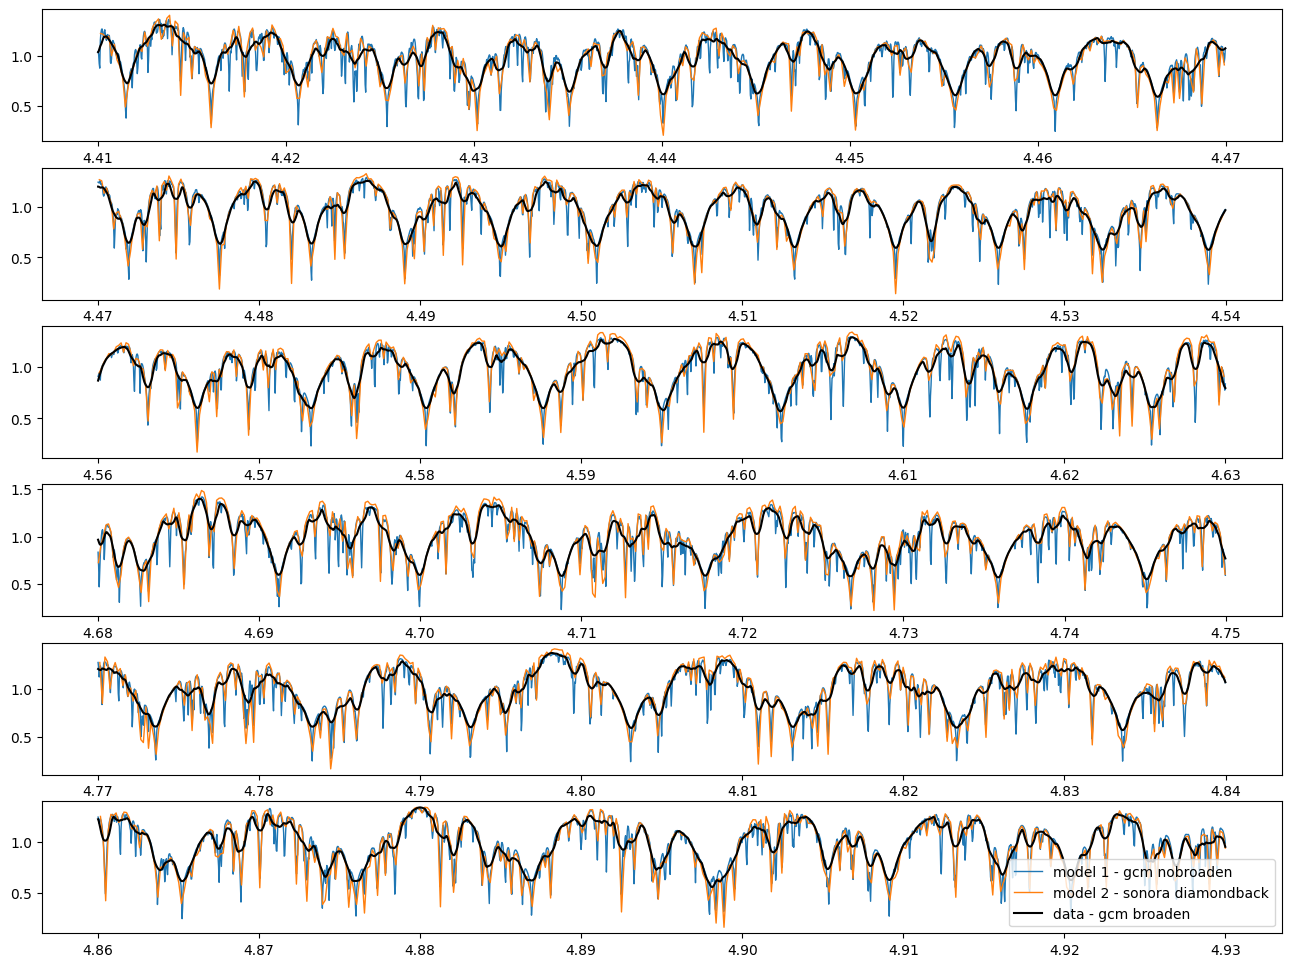

In [22]:
t=0
rvgcm = 9.e-5 #um
rvgcm = 0
plt.figure(figsize=(16,12))
for c in range(nchip):
    wlmin, wlmax = m_orders[c]
    wlind = np.where((modwl>wlmin) & (modwl<wlmax))[0]
    print(len(wlind))
    plt.subplot(nchip,1,c+1)
    plt.plot(wav[c]*(1+rvgcm), template[t,c], color='tab:blue', lw=1, label=f'model 1 - gcm nobroaden')
    plt.plot(modwl[wlind], modflux[wlind]/np.nanmedian(modflux[wlind]), color='tab:orange', lw=1, label=f'model 2 - sonora diamondback')
    plt.plot(wav[c]*(1+rvgcm), observed[t,c], color='k', label=f'data - gcm broaden')
plt.legend()

Checking fits

In [23]:
resultdir = f"{homedir}/uoedrive/result/fitted/diamondback"
reslist = sorted(glob.glob(f'{resultdir}/METIS_W1049B_M_*.txt'))
chisq_avg = []
chisq_min = []
modelname = []
for file in reslist:
    data = np.loadtxt(file, skiprows=1)
    order, obs, chisq, vsini, lld, rv = data.T
    chisq_avg.append(np.nanmean(chisq))
    chisq_min.append(np.nanmin(chisq))
    modelname.append(file.split(".")[-2][-12:])

In [26]:
# sort chisq
modelname, chisq_min, chisq_avg = zip(*sorted(zip(modelname, chisq_min, chisq_avg), 
    key=lambda x: x[2]))
for i in range(10):
    print(modelname[i], chisq_min[i], chisq_avg[i])

t1400g1000f8 0.08 0.10925
t1400g1000nc 0.07 0.11200000000000002
t1500g1000nc 0.09 0.11366666666666667
t1100g1000f3 0.1 0.14016666666666663
t1300g1000f3 0.1 0.15141666666666662
t1300g1000f8 0.1 0.15649999999999997
t1600g1000nc 0.12 0.15658333333333332
t1200g1000f3 0.12 0.16191666666666665
t1700g1000nc 0.13 0.17475
t1200g1000f4 0.14 0.17908333333333334


In [28]:
bestmodelname = 't1400g1000f8'
with open(f'{resultdir}/METIS_W1049B_M_{bestmodelname}.pickle', 'rb') as f:
    data = pickle.load(f)
res = np.loadtxt(f'{resultdir}/METIS_W1049B_M_fitting_results_{bestmodelname}.txt', skiprows=1)
order, obs, chisq, vsini, lld, rv = res.T
rvs = np.nanmedian(rv.reshape(nchip, 20), axis=1)
rvs

array([1.7150e-06, 1.9275e-12, 3.4000e-08, 8.0550e-07, 2.2850e-06,
       7.3800e-08])

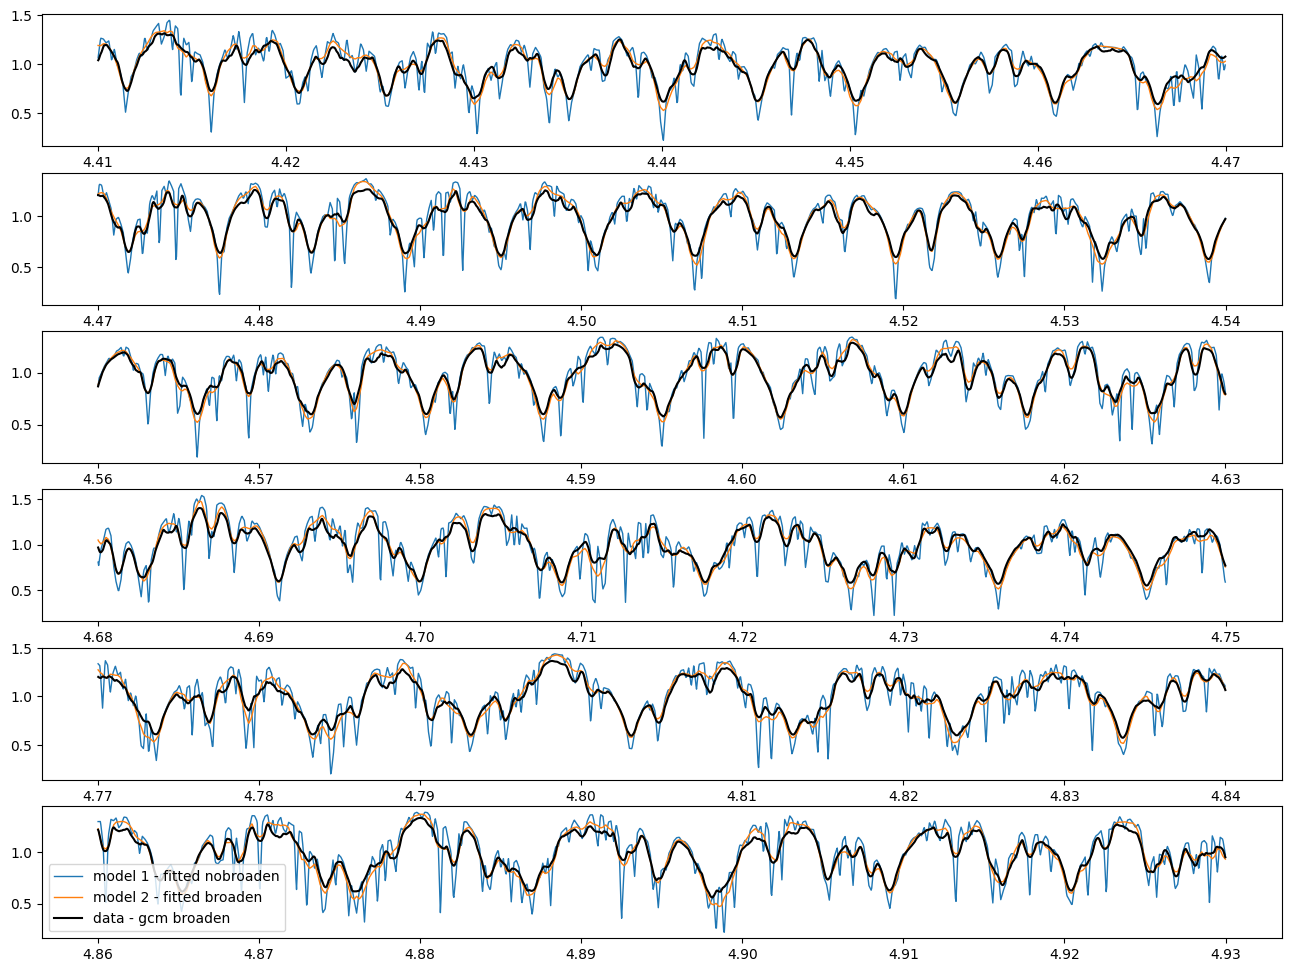

In [31]:
t=0
rv = [25.e-5, 15.e-5, 6e-5, 1.8e-05]
plt.figure(figsize=(16,12))
for c in range(nchip):
    wlmin, wlmax = m_orders[c]
    wlind = np.where((modwl>wlmin) & (modwl<wlmax))[0]
    plt.subplot(nchip,1,c+1)
    plt.plot(data['chiplams'][t,c], data['chipmodnobroad'][t,c], color='tab:blue', lw=1, label=f'model 1 - fitted nobroaden')
    plt.plot(data['chiplams'][t,c], data['chipmods'][t,c], color='tab:orange', lw=1, label=f'model 2 - fitted broaden')
    plt.plot(data['chiplams'][t,c]*(1+rvs[c]), data['observed'][t,c], color='k', label=f'data - gcm broaden')
plt.legend()

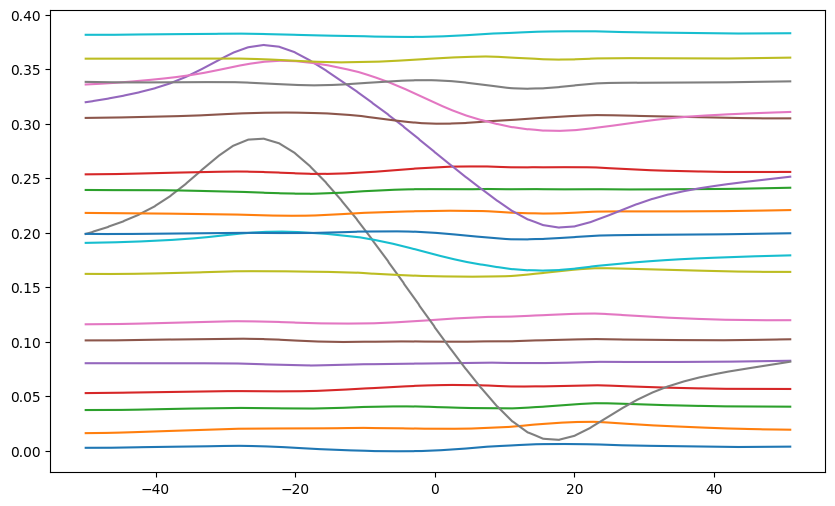

In [32]:
# Constants
c_km_s = 3e5  # Speed of light [km/s]

def doppler_shift_flux(wl_obs, wl_rest, flux_rest, rv):
    """Doppler-shift model flux to observer frame."""
    wl_rest_for_obs = wl_obs / (1 + rv / c_km_s)
    return np.interp(wl_rest_for_obs, wl_rest, flux_rest, left=1, right=1)

def compute_ccf(wl_data, data_resid, wl_model, model_resid, rv_grid):
    """Compute normalized CCF over RV grid."""
    ccf = np.zeros(len(rv_grid))
    for i, rv in enumerate(rv_grid):
        model_interp = doppler_shift_flux(wl_data, wl_model, model_resid, rv)
        ccf[i] = np.sum(data_resid * model_interp)
    ccf /= np.max(np.abs(ccf))  # Normalize
    return ccf

ccfs = []
for t in range(20):
    c = 3
    wl = data['chiplams'][t,c] # High-res grid
    #true_rv = 5.0  # True planet RV [km/s]
    model_flux = data['chipmodnobroad'][t,c]
    data_flux = data['observed'][t,c]
    data_resid = data_flux - 1  # Residuals (subtract continuum)
    model_resid = model_flux - 1

    # Compute CCF
    rv_grid = np.arange(-50, 51, 0.1)
    ccf = compute_ccf(wl, data_resid, wl, model_resid, rv_grid)
    ccfs.append(ccf)

ccfs = np.array(ccfs)

plt.figure(figsize=(10,6))
for t in range(20):
    plt.plot(rv_grid, ccfs[t]-np.nanmedian(ccfs,axis=0)+0.02*t, label=f'Time {t}')

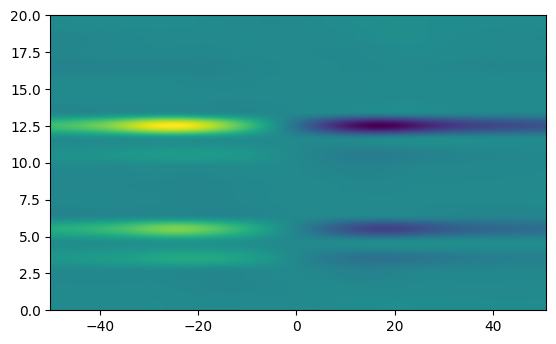

In [33]:
plt.imshow(ccfs-np.nanmedian(ccfs,axis=0), aspect=3, extent=[rv_grid[0], rv_grid[-1], 0, 20], cmap='viridis')

In [90]:
def make_deltaspec(loc, ew, win, **kw):
    """
    Create a delta-function line spectrum based on a wavelength grid
    and a list of line locations and equivalent widths.

    :INPUTS:
       loc -- location of lines in the emission frame of reference

       ew  -- equivalent widths of lines, in units of wavelength grid.
               Positive values are emission lines.

       win -- wavelength grid in the emission frame, with values
              monotonically increasing (best if it is linearly spaced)

       All inputs should be lists or one-dimensional arrays of scalars

    :OPTIONAL_INPUTS:
       cont=None -- set continuum values in the emission frame;

       nearest=False  -- if True, use full pixels instead of partial

       verbose=False  -- if True, print out various messages

    :OUTPUTS:
      s  -- delta-function line spectrum, with a continuum level of zero
    
    :EXAMPLE: (NEEDS TO BE UPDATED!):
       ::

          w   = [2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7]
          loc = [2.1, 2.35, 2.62]
          ew  = [0.1, .02, .01]
          s = linespec(loc, ew, w)
          print s  #  --->  [0, 1, 0, 0.1, 0.1, 0, 0.08, 0.02]

    :NOTE:  This may give incorrect results for saturated lines.
    """
    # 2008-12-05 13:31 IJC: Created
    # 2008-12-10 13:30 IJC: Added continuum option, reworked code some.
    # 2008-12-12 12:33 IJC: Removed RV option

    # Check inputs
    loc = np.array(loc).copy().ravel()
    ew  = np.array(ew ).copy().ravel()
    win = np.array(win).copy().ravel()

    defaults = dict(cont=None, nearest=False, verbose=False)
    for key in defaults:
        if (not key in kw):
            kw[key] = defaults[key]
    verbose = bool(kw['verbose'])
    nearest = bool(kw['nearest'])
    contset = kw['cont']!=None

    if contset:
        cont = np.array(kw['cont']).copy()
        if len(cont)!=len(win):
            print( "Wavelength grid and continuum must have the same length!")
            return -1
    else:
        cont = np.ones(win.shape)

    nlines = len(loc)
    if nlines != len(ew):
        if verbose:  print( "len(loc)>>" + str(len(loc)))
        if verbose:  print( "len(ew)>>" + str(len(ew)))
        print( "Line locations and equivalent widths must have same length!")
        return -1

    # Only use lines in the proper wavelength range
    nlineinit = len(loc)
    lind = (loc>=win.min()) * (loc<=win.max())
    loc = loc[lind]
    ew  =  ew[lind]
    nlines = len(loc)

    s = cont.copy()
    d = np.diff(win).mean()

    if verbose:  print( "s>>" + str(s))

    for ii in range(nlines):
        lineloc = loc[ii]
        lineew  = ew[ii]
        index = (win<lineloc).sum() - 1
        if nearest:
            s[index+1] = s[index]-cont[index]*lineew/d
        elif index==len(win):
            s[index] = s[index] - cont[index]*lineew/d
        else:
            s[index] = s[index] - lineew*cont[index]* \
                (win[index+1] - lineloc)/d/d
            s[index+1] = s[index+1] - lineew*cont[index+1] * \
                (lineloc - win[index])/d/d
        
        if verbose:  
            print( "(lineloc, lineew)>>" + str((lineloc, lineew)))
            print( "(index, d)>>" + str((index,d)))

    if verbose:
        print( "(nlineinit, nline)>>" + str((nlineinit, nlines)))
    return s

In [141]:
line_file = f'../data/linelists/linbroad_t1500g1000f8_edited.clineslsd'
with open(line_file, 'r') as f:
    raw = f.readlines()
dat = np.zeros([len(raw), 2], dtype=float)                                                 
for i, line in enumerate(raw):                                         
    dat[i,:]= list(map(float, line.split()[0:2]))
lineloc = dat[:,0]/1e4
lineew = dat[:,1]/1e3

rv=9e-5
shift = 1. + rv
wlind = np.where((wl>2.25) & (wl<2.35))
dwl = wl[wlind]
deltaspec = make_deltaspec(lineloc*shift, lineew, dwl, verbose=False)

In [143]:
spec_nobroad_all = []
for t in range(20):
    spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time{t+1}.txt")
    spec_nobroad_all.append(spec_nobroad)
spec_nobroad_all = np.array(spec_nobroad_all)
spec_nobroad_all.shape

(20, 460654)

In [10]:
wav.shape

(4, 1550)

In [15]:
np.diff(wl).mean()

9.1468790608115e-06

In [24]:
from scipy.interpolate import interp1d
spec_nobroad_mean = np.nanmedian(spec_nobroad_all,axis=0)
wl_lin = np.arange(1.51, 2.50+0.05*1e-4, 0.05*1e-4, dtype=np.float32)  # Include endpoint
interp_func = interp1d(wl, spec_nobroad_mean, kind='linear', bounds_error=False, fill_value=0.0)
spec_nobroad_lin = interp_func(wl_lin)
spec_nobroad_lin.shape

(198001,)

In [25]:
# save 'model' to fits

hdu = fits.PrimaryHDU(spec_nobroad_lin.astype(np.float32))

# WCS header keywords
hdu.header['CRPIX1'] = 1                     # Reference pixel
hdu.header['CRVAL1'] = 15100          # Wavelength at reference pixel
hdu.header['CDELT1'] = 0.05           # Step size
hdu.header['CTYPE1'] = 'LINEAR'

# Write to FITS
hdu.writeto(f'{datadir}/w1049b_gcmhires_nobroad_lin.fits', overwrite=True)

In [144]:
# prepare pickle file
saveout = dict(
    chiplams=np.tile(wav, (20, 1, 1)), 
    chipmodnobroad=template, 
    observed=observed, 
    error=error)
with open(f'../data/fitted/ELT_W1049B_K_gcm.pickle', 'wb') as f:
    pickle.dump(saveout, f)

### Plot flux maps

In [ ]:
fluxmap = np.loadtxt(f"{datadir}/bolometric_flux_map_data/spectrum_erg.s.cm3_broaden_time1.txt")

In [166]:
# Initialize parameters
ntracer = 7  # number of tracers of the GCM.  
							#tracer 1 is silicate vapor, tracer 2 and 3 are silicate
              # cloud mode 1 and 2; tracer 4 is Fe vapor and tracer 5 is
            	# Fe cloud; tracer 6 is Na2S vapor and tracer 7 is Na2S cloud

# Read information of the GCM
with open(f'{datadir}/bolometric_flux_map_data/infmitgcm.txt', 'r') as f:
    lines = f.readlines()
    # Find maximum number of columns
    max_cols = max(len(line.split()) for line in lines)
    # Pad shorter rows with NaN
    data = []
    for line in lines:
        parts = line.split()
        if len(parts) < max_cols:
            parts += ['NaN'] * (max_cols - len(parts))
        data.append(parts)
    inf = np.array(data, dtype=float)

# Extract parameters 
nlx = int(inf[0, 0])     # number of longitude points
nly = int(inf[0, 1])     # number of latitude points
Nr = int(inf[0, 2])      # number of vertical layers
ntime = 20 #int(inf[0, 3])   # number of time outputs
pc = inf[2, :Nr]         # pressure grid, unit [Pa]
xi = inf[6, :nlx]        # longitude grid, unit [degree]
yi = inf[7, :nly]        # latitude grid, unit [degree]
deltaT = 940.5 #inf[5, 0]       # time step of the GCM, second
gravity = inf[1, 0]      # surface gravity, unit [m/s2]
rSphere = inf[1, 1]      # radius, unit [m]
rotationperiod = inf[1, 2]  # rotation period, unit [second]
timeout = 1200004. + np.arange(ntime) * deltaT #inf[4, :ntime]    # time steps of outputs
print(f"ntime={ntime}, deltaT={deltaT}, period={rotationperiod}, timeout={timeout}")

# Read tracer array
with open(f'{datadir}/bolometric_flux_map_data/fluxtopmitgcm.dat', 'rb') as f:
    tempe = np.fromfile(f, dtype=np.float32, count=nlx*nly*ntime)
flux = tempe.reshape((nlx, nly, ntime), order='F')
flux[:, 0, :] = flux[:, 1, :]
flux[:, -1, :] = flux[:, -2, :]

ntime=20, deltaT=940.5, period=19008.0, timeout=[1200004.  1200944.5 1201885.  1202825.5 1203766.  1204706.5 1205647.
 1206587.5 1207528.  1208468.5 1209409.  1210349.5 1211290.  1212230.5
 1213171.  1214111.5 1215052.  1215992.5 1216933.  1217873.5]


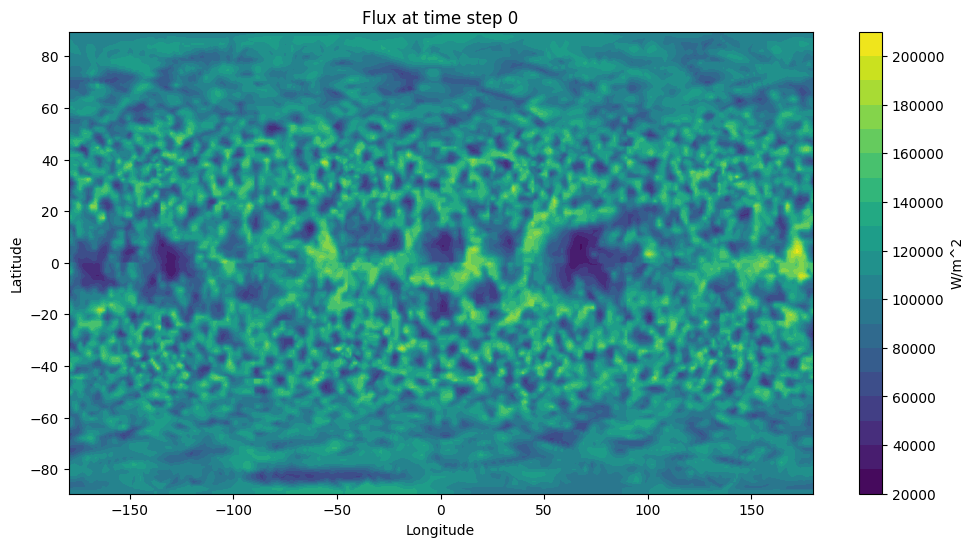

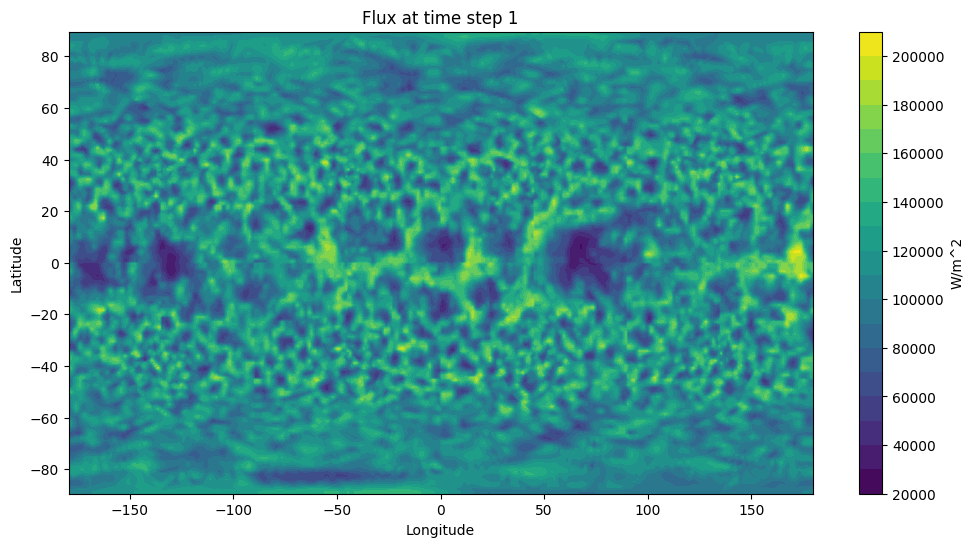

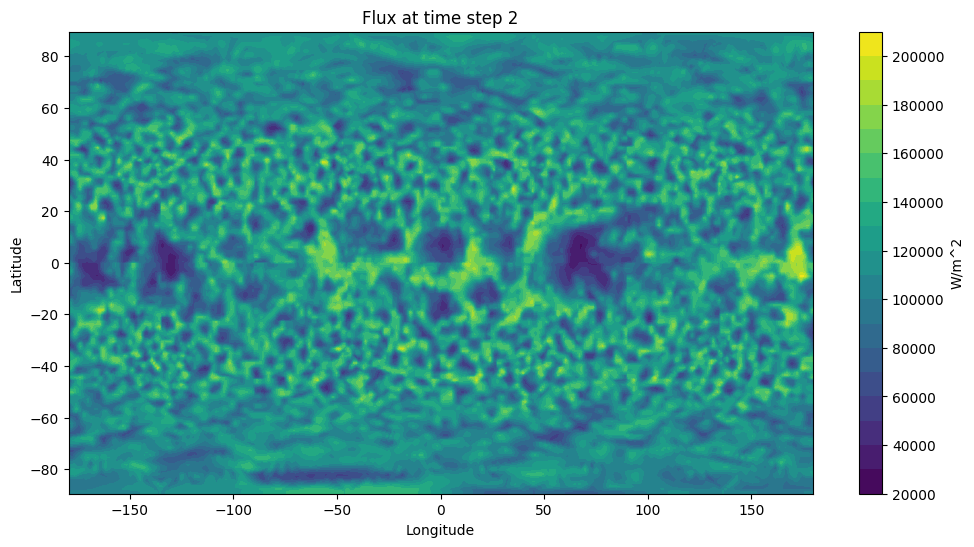

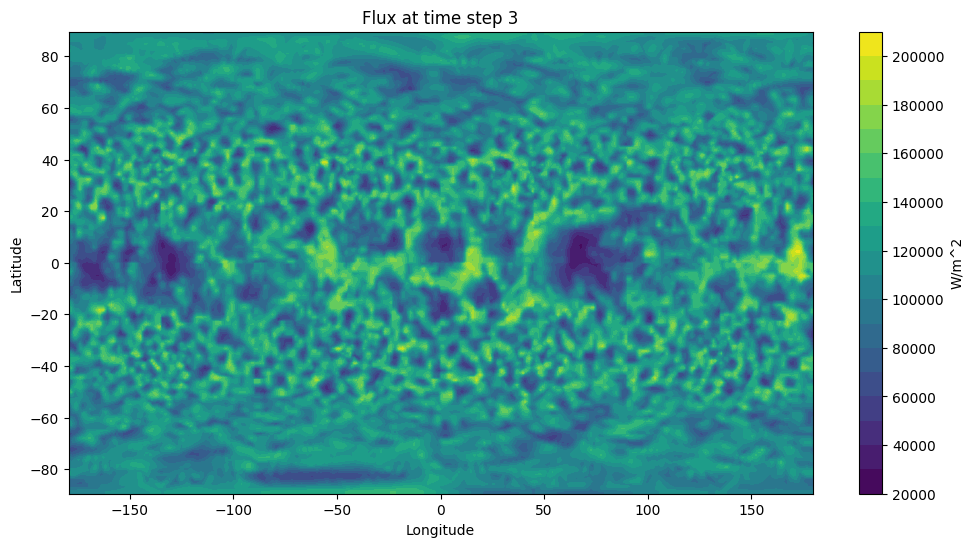

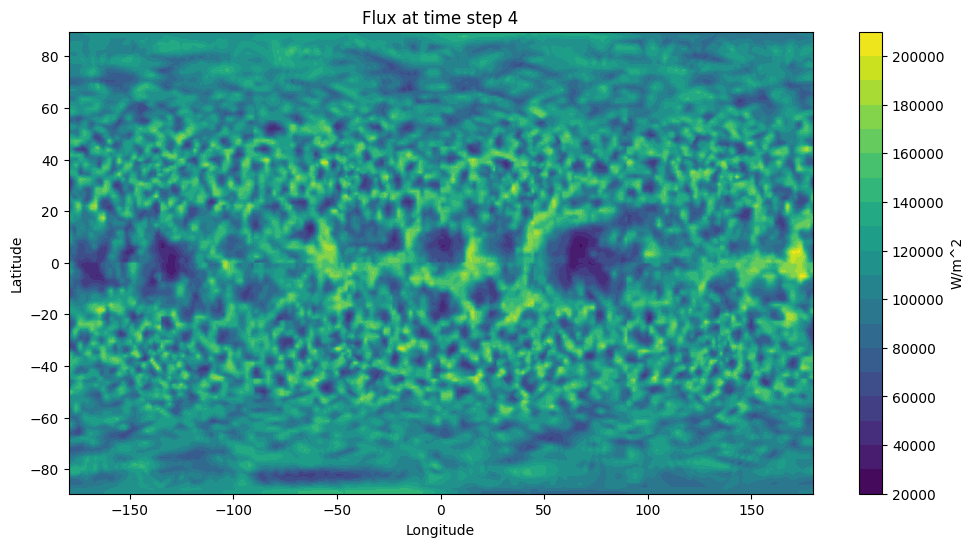

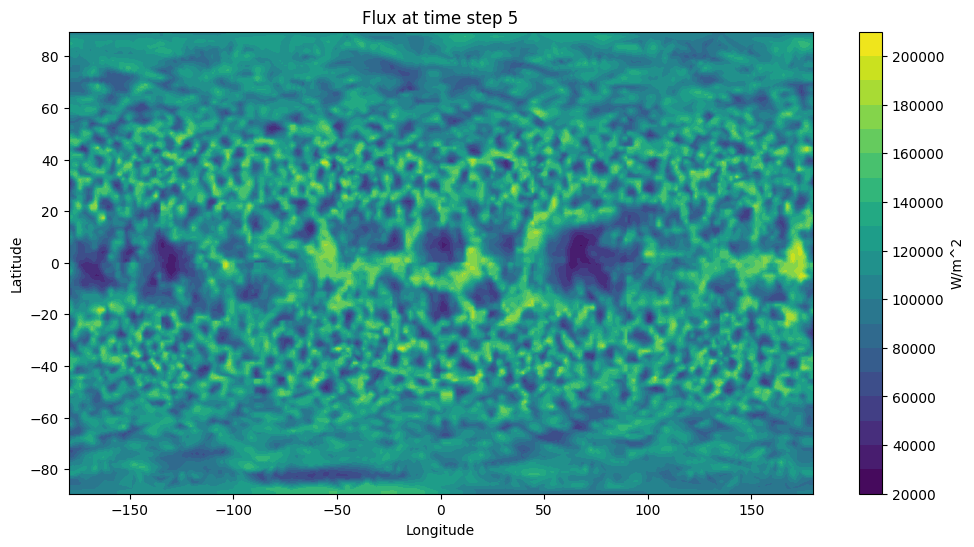

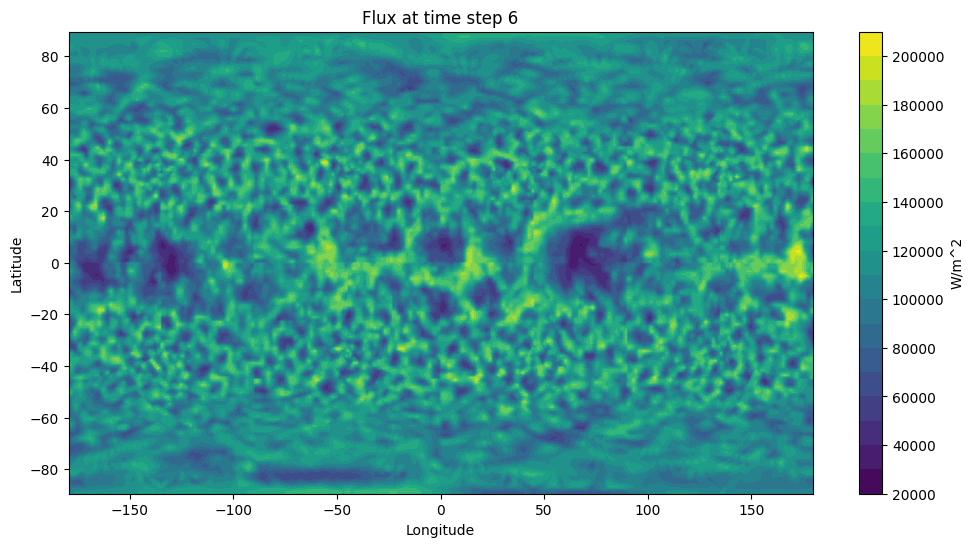

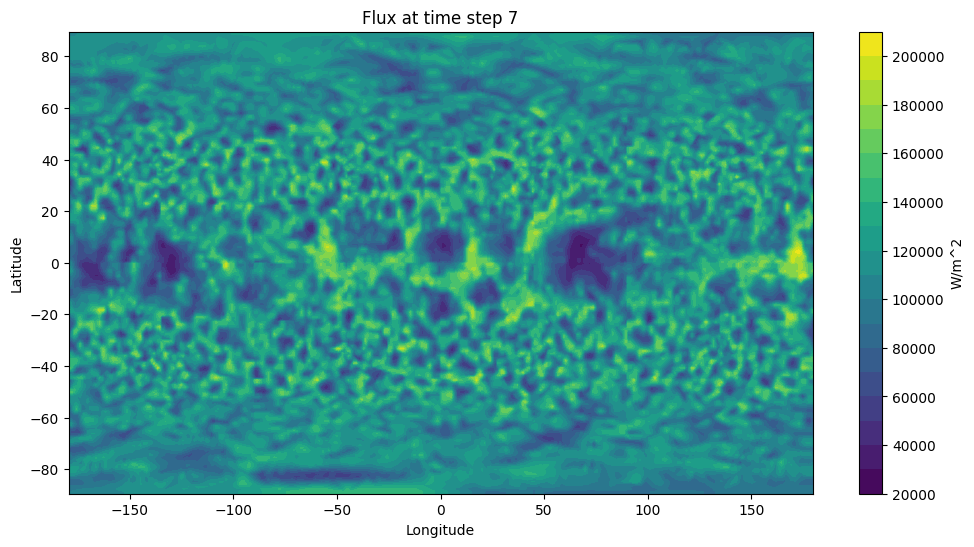

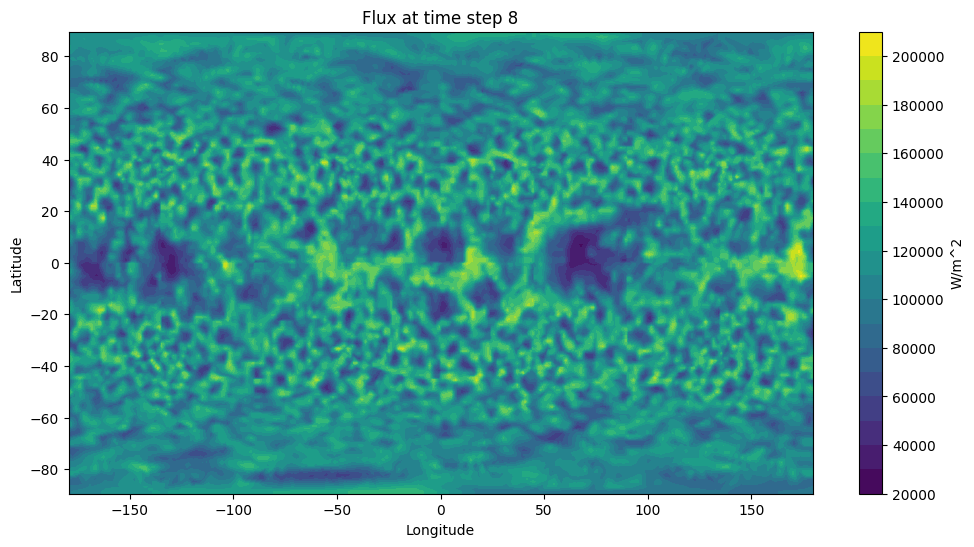

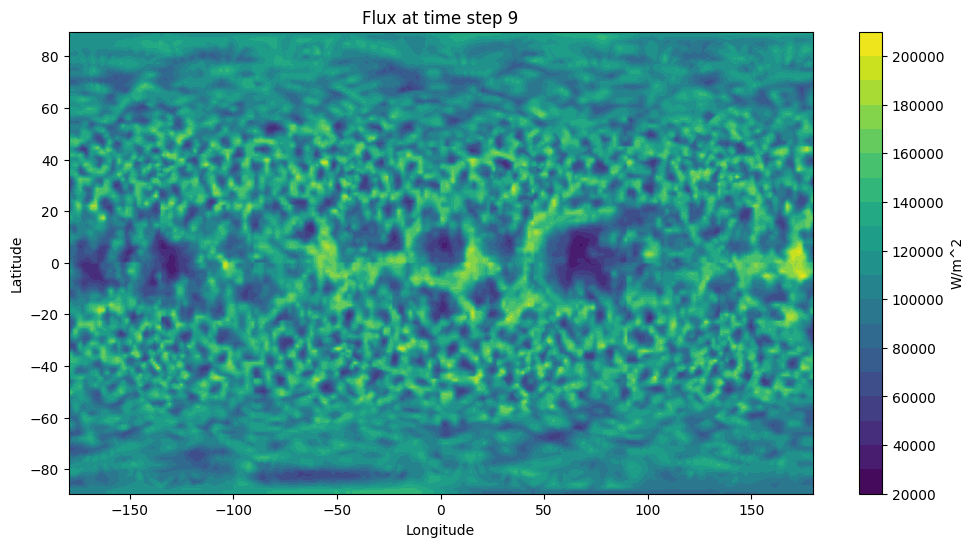

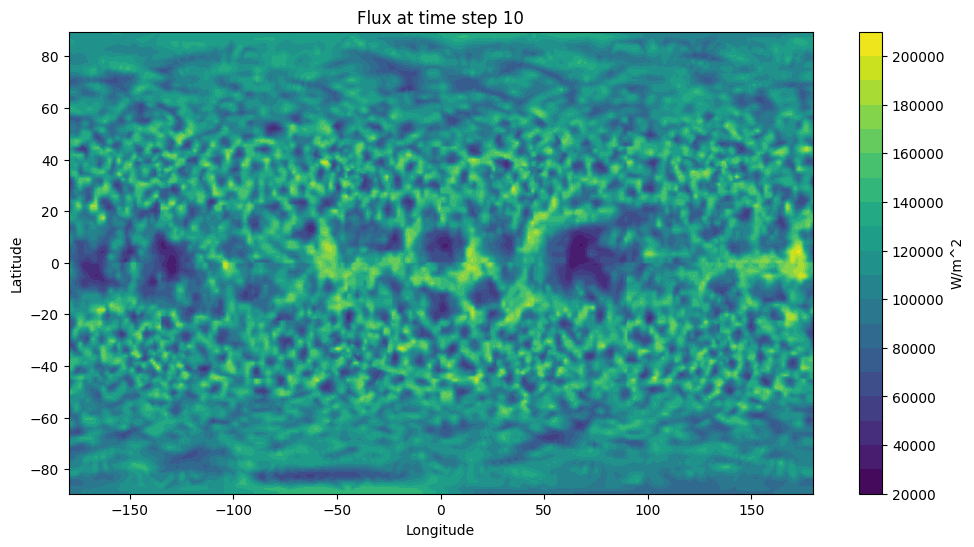

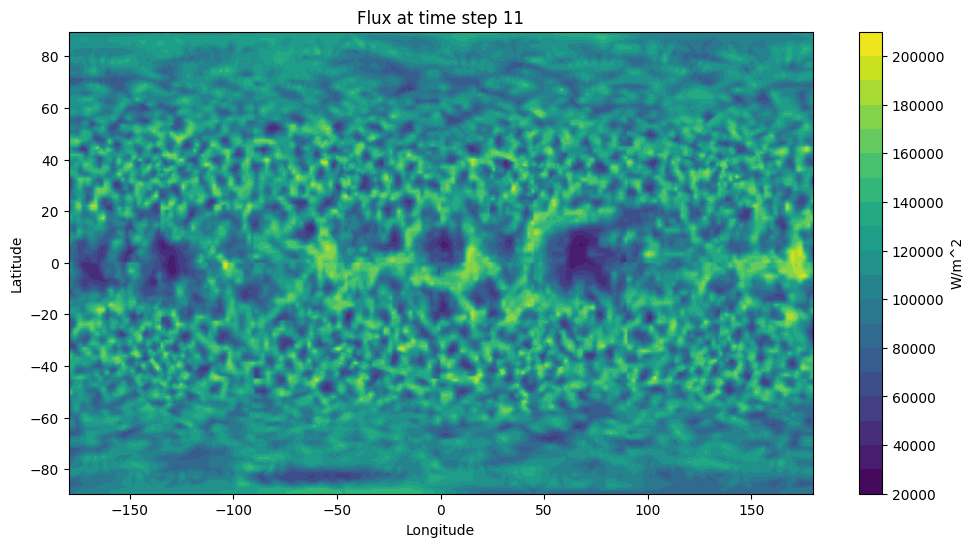

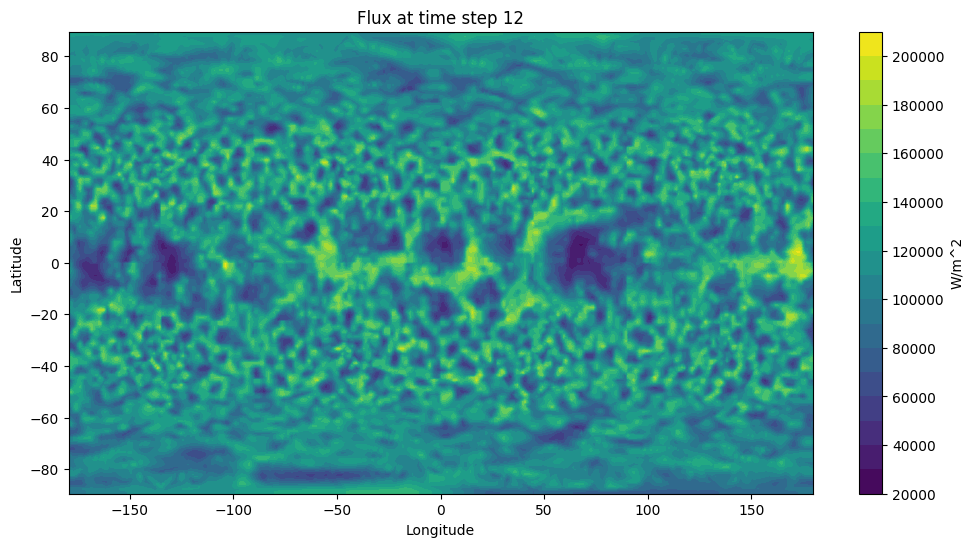

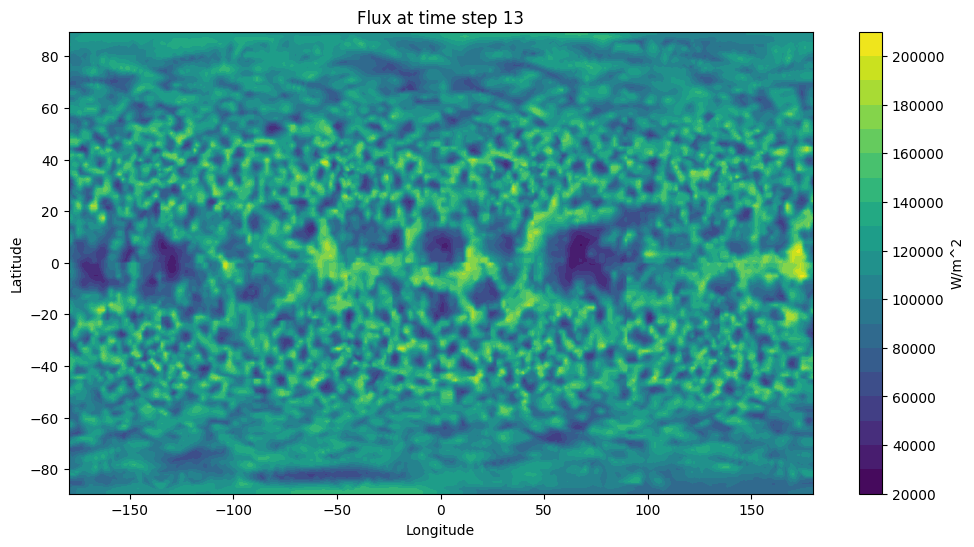

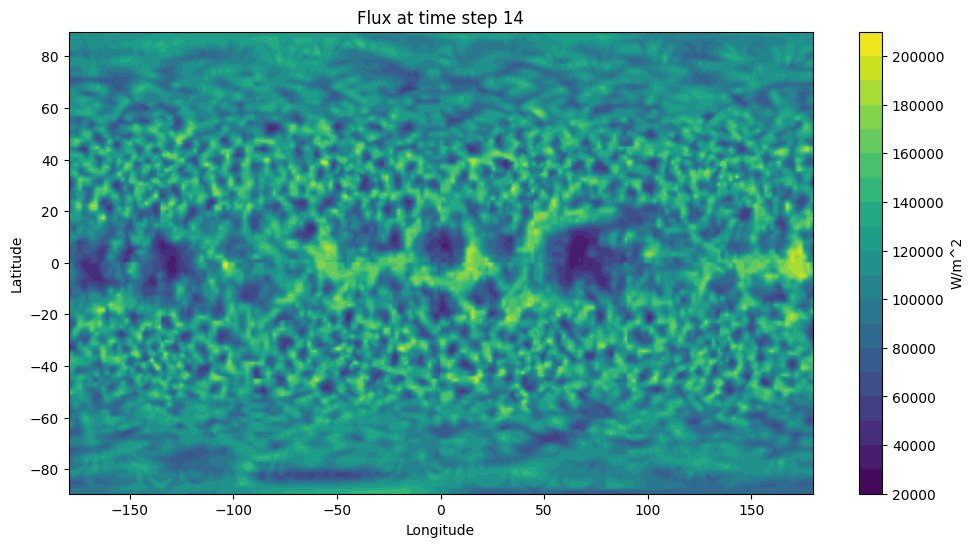

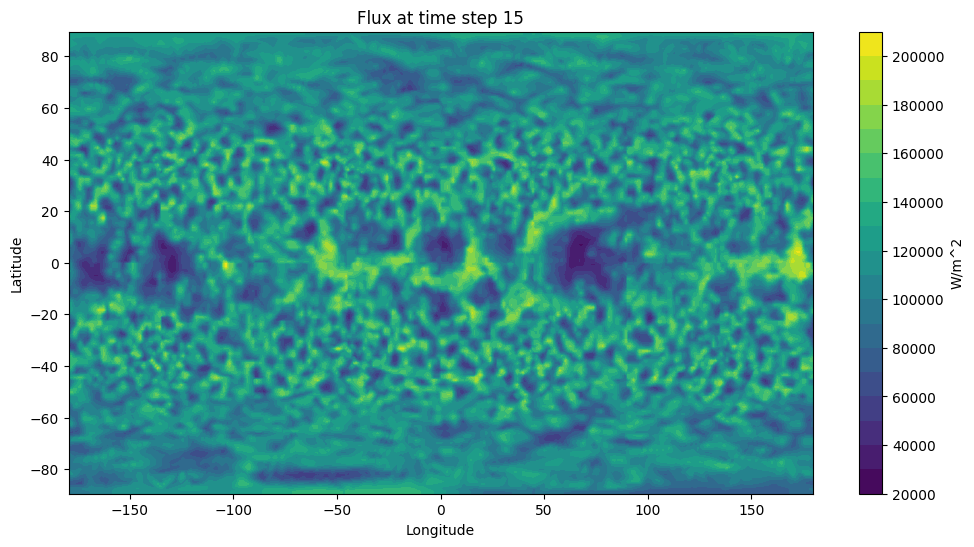

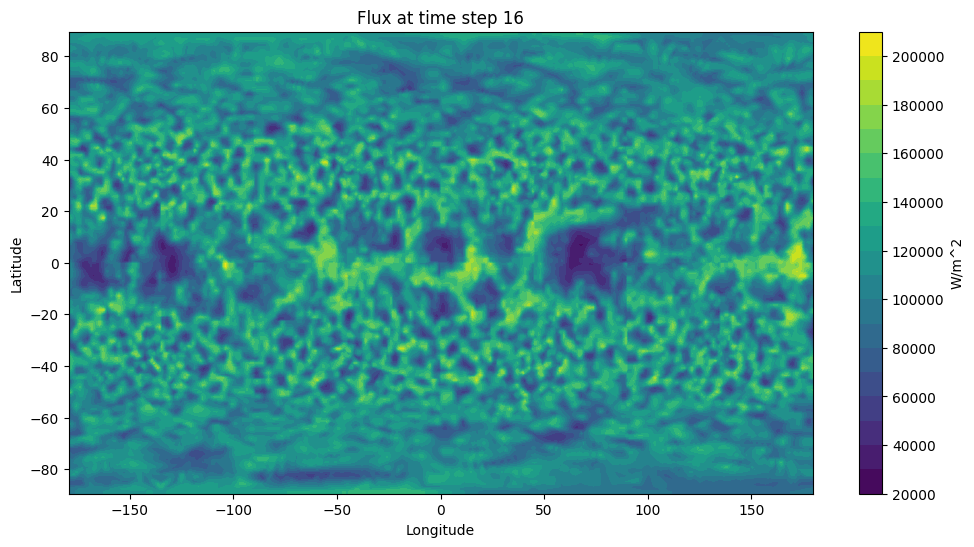

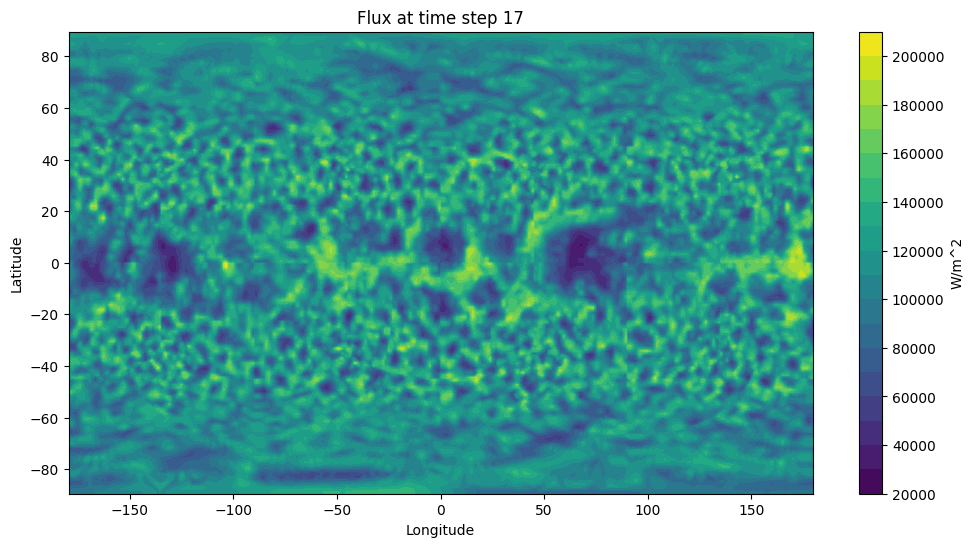

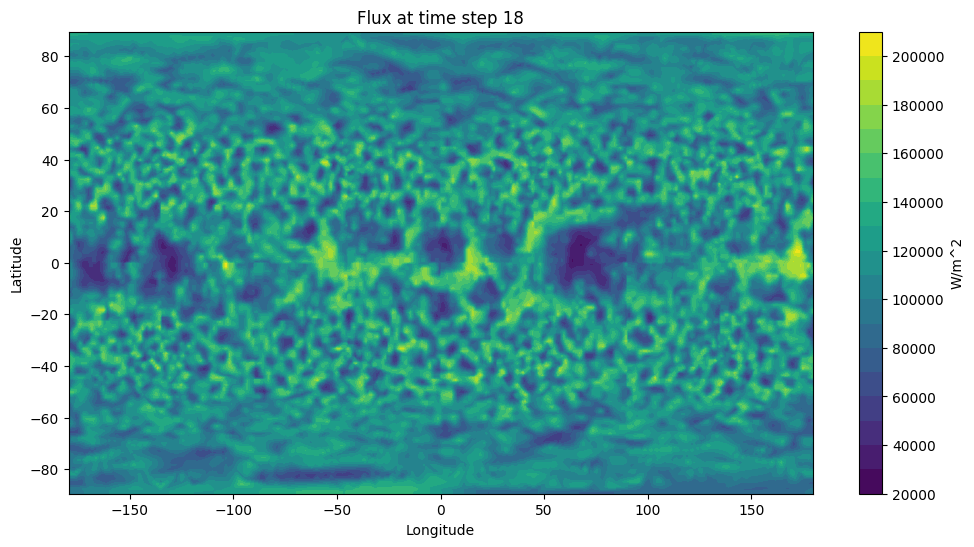

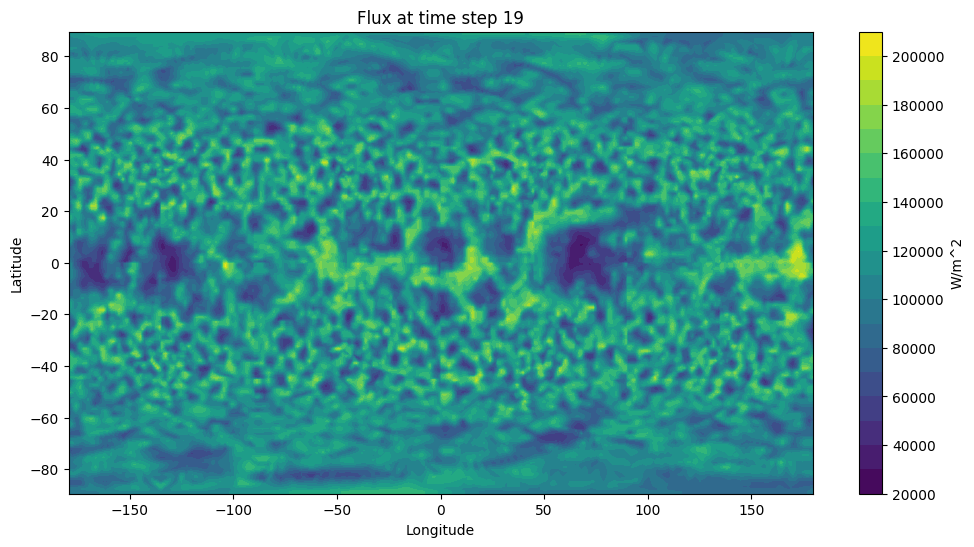

In [167]:
# Plotting
nlayer = 19  # 0-based indexing for 20th layer
timeuse = 20

for timeuse in range(20):
    plt.figure(figsize=(12, 6))

    plt.contourf(xi, yi, flux[:, :, timeuse].T, levels=20, cmap='viridis')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    cbar = plt.colorbar()
    cbar.set_label('W/m^2')
    plt.title(f'Flux at time step {timeuse:.0f}')
    plt.savefig(f'{datadir}/bolometric_flux_map_data/flux_map_time{timeuse}.png', dpi=100)

plt.show()